# Overview

The following steps are taken for the analysis of sentiments over time around the VW scandel.

* [News filtering](#news_filtering)
    * Simple filtering with keywords
    * Sanity check of filtering results
    
* [Improve the sample](#heuristic_filtering)
    * Motivation
    * Manual inspect: some items are not relevant to Volkswagen
    * Relation between title mention and relevance
    * Heuristic rules for further filtering
    * Possible further improvement
    
* [Sentiment analysis](#sentiment_analysis)
    - Sentiment over time
    - Impact of sentiment: the size of audiance
* Sentiment terms
* Related entities


## Ground truth (check points)
* According to Wikipedia, the following points on the timeline are of interest:
    - 3rd Sep EPA threatens to not certify 2016 diesels
    - 18th Sep the Public announcement by EPA of order to recall 2009–2015 cars 
    - 20th Sep VW had an initial public response
    - 22nd Sep VW admitted the install of defeat device
    - 23rd Sep VW CEO resigned, VW started defense.
    - 28th Sep VW suspended a number of people and started internal investigation
* I will use these as check points, and see how the result of sentiment analysis reflects/is influenced by these events.

In [105]:
# Setups.
%matplotlib inline
import re
import util
import itertools as it
import numpy as np
from scipy.stats import ranksums, normaltest
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
import random

import nltk 
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Only use data after the initial filtering: items containing "wolkswagen" case insensitive.
VWdata = 'data/Volkswagen.jsonl'
VWscandaldata = 'data/Volkswagen_scandal.jsonl'
# Some additional resources
WP_VW = 'data/vw_wp_full.txt'


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jiyinhe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jiyinhe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id="news_filtering"></a>

# 1. Filtering news 

## 1.1 Simple filtering with key words

###  Sample 0:  News items about VW
* A gentle filtering that filters all items containing the word "volkswagen" case insensitive. 
     - We want to look at the sentiment change before, during, and after the scandal, so it is necessary to keep news that are not about scandals.
     
### Sample 1:  News items about VW emission scandal
* Filter from the result of step 0 with words "emission" and/or "scandal"

### Assumptions:
* A news item about VW should mention its full name at least once in title/content, otherwise its writing quality is questionable.
* To talk about the scandal, "emission" will most likely to be mentioned. "scandal" is not necessarily mentioned, but if "scandal" is metioned, it is very likely referred to the emission scandal.
* A news item mentioning these words may not actually about VW or its scandal.

### Consequence:
* The filtering is high recall, may have precision issue. 

In [94]:
# Filtering Step 0: 
# $zgrep -i volkswagen signalmedia-1m.jsonl.gz > data/Volkswagen.jsonl
D_VW = util.load_jsonl(VWdata)

# Filtering Step 1: 
# $egrep -i '(emission)|(scandal)' data/Volkswagen.jsonl > data/Volkswagen_scandal.jsonl
# We have loaded this data to variable 
D_VWS = util.load_jsonl(VWscandaldata)

## 1.2  Filtered data: distribution over time by day
### Observation
* More news items about VW as the event progress (initially around 09-03, and full outbreak after 09-18)
* News mentioning emission/scandal dominate after 09-18 following EPA's public announcement.

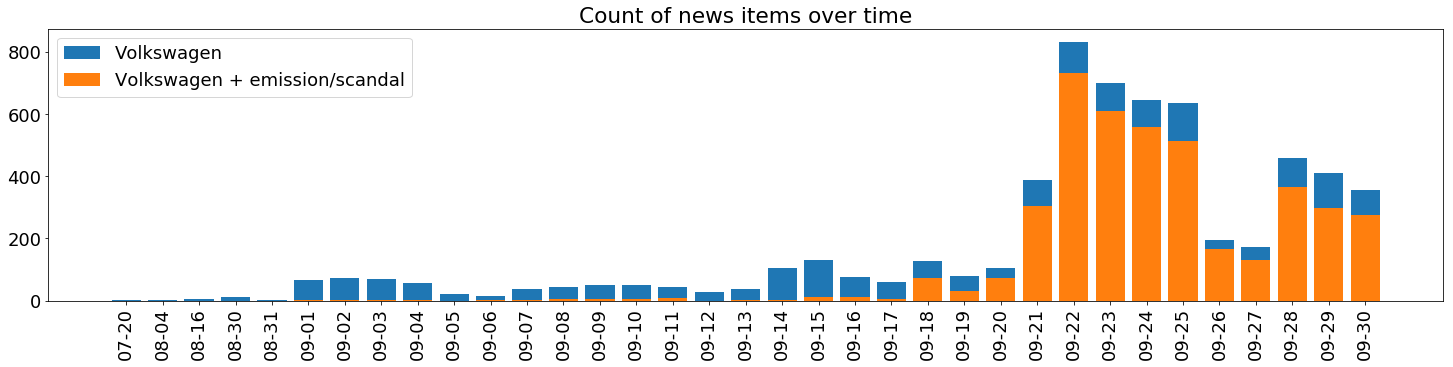

Total number of news mentionning "Volkswagen": 6087
Total number of news mentionning "Volkswagen" and "emission/scandal": 4186


In [95]:
# Plot count of news over dates
def prep_counts(data):
    """Count the number of items per day"""
    D = [util.get_date(d['published']).replace('2015-', '') for d in data]
    D.sort()
    counts = []
    for k, g in it.groupby(D):
        counts.append((k, len(list(g))))
    return dict(counts)

def plot_counts(D_VW, D_VWS):
    # make plot
    fig, ax = plt.subplots(figsize=(25, 5))
    C1 = prep_counts(D_VW)
    C2 = prep_counts(D_VWS)
    X = sorted(list(set(list(C1.keys()) + list(C2.keys()))))
    Y1 = [C1.get(x, 0) for x in X]
    Y2 = [C2.get(x, 0) for x in X]
    bar_width = 0.8
    bar1 = ax.bar(X, Y1, bar_width, label="Volkswagen")
    bar2 = ax.bar(X, Y2, bar_width, label="Volkswagen + emission/scandal")
    ax.set_title("Count of news items over time")
    ax.legend(handles=[bar1, bar2])
    ax.set_xticklabels(X, rotation="vertical")
    plt.show()
    print('Total number of news mentionning "Volkswagen": %s'%len(D_VW))
    print('Total number of news mentionning "Volkswagen" and "emission/scandal": %s'%len(D_VWS))

plot_counts(D_VW, D_VWS)

<a id="heuristic_filtering"></a>
# 2. Improve the sample

## 2.0 Motivation
For our analysis, precision is perhaps more important than recall, i.e. we can live with a smaller sample, but it should be mostly about VW or VW scandal.

## 2.1 A brief manual inspection found that some items are not really related to VW,  e.g. :
* Articles consisting of advertisement/listing of headlines
* Articles that are remotely related, e.g. article about "how to test emission" 
* Many of the items that don't have Volkswagen/VW in their titles are obviously not relevant.
* Some items have relevant titles, but the content are not relevant, e.g.
    - An error occurred when retrieving the content, or a login was required -- i.e. no real content
    - The content only contains one sentence.
    
## 2.2 A quantitative investigation, considering filtering heuristics:

### Method
1. Relevance to Volkswagen by:
    * Using the **Wikipedia page on VW (referred to as WP_VW hereafter)** as example, check
        - Similarity of the filtered VW news items to WP_VW
        - **Similarity measure**: cosine similarity
        - **Doc representation**: TFIDF term vector
2. Check importance of titles as indicator of relevance to VW:
    * Check distribution of similarity scores wrt. WP_VW over articles with and without VW/Volkswagen mentioned in titles 
    * Hypothesis testing whether two distributions have the same mean. 
    

In [96]:
""" Data preperation 
# Nothing fancy, let's use tfidf and cosine similarity for this task
"""
WP_VW_text = util.load_txt(WP_VW)
    
# Collect all docs including WP_VW, WP_VW_scandal, and news items
# Using this set as the background collection to compute IDF.
all_docs = [WP_VW_text] + [d['content'] for d in D_VW]

# Convert to term vectors
vectorizer = TfidfVectorizer()
vecs = vectorizer.fit_transform(all_docs)
# Compute similarity to WP page about Volkswagen
sims = np.zeros(vecs.shape[0]-1)
for i in range(1, vecs.shape[0]):
    sims[i-1] = cosine_similarity(vecs[0, :], vecs[i, :])

### Observations
* The group of no title mention has a lower similarity score to the Wikipedia page on Volkswagen compared to the group with title mention, statistically significatn.
* Both groups have low and high similarity scores
    * e.g. high score with no title mention where Volkswagen was misspelt. 
    * e.g. low score with title mention where retrieval of the document encountered error.
* Manual inspections: 
    1. Among the top **50** items **similar** to WP_VW **without title mention** 
        - 8 items are about Volkswagen (including 2 duplicated items).
    2. Among the top **50** items **dissimilar** to WP_VW **with title mention**
        - 9 items are about Volkswagen, and all of them are very short (e.g. one sentence summary). 
    3. Inspect items with title mention, take bins of their similarity scores to WP_VW page, and inspect 10 random samples from each bin, we see:
        - in similarity scores range (0., 0.05): 3/10 relevant, mostly short messages.
        - in similarity scores range (0.05, 0.1): 7/10 relevant.
        - in similarity scores range (0.1, 0.2): 8/10 relevant, and an advertisement that is about VW.
        - in similarity scores range (0.2, ): 10/10 relevant.
        
### Heuristics derived:
Based on the above observations, we can make the following heuristics to further filter the results:
* Remove items without title mention.
    - This will remove most of the irrelevant items (see manual inspection 1). 
    - Relevant items may also be removed, but will not be many. We can live with a smaller but more accurate sample.
* Remove items with a similarity score to the WP_VW page lower than 0.05.
    - This will remove most of the irrelvant items (see manual inspection 3).
    - Few irrelevant items may remain. For now we don't have a better way to handle it without labelled data.

Number of items with title mention vs. without title mention: 3522 vs. 2565
Normality testing result - title-mention: p-value=0.00; without mention: p-value=0.04

Test difference between the two groups with Wilconxon ranksum test (sample not normalily distributed)
Ranksum testing result: stats: 23.98, p-value=0.00


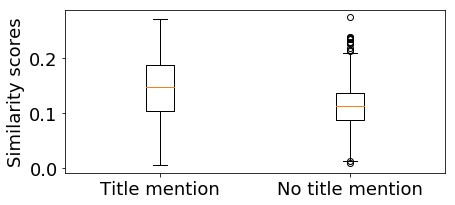

In [179]:
# Relation between the mention of "volkswagen" in title and the similarity scores
# Get items whose titles contain "Volkswagen or VW"
in_title = list(filter(lambda x: re.search(r'volkswagen|VW|emission|scandal', x['title'], re.I), D_VW))
out_title = list(filter(lambda x: re.search(r'volkswagen|VW|emission|scandal', x['title'], re.I) == None, D_VW))
print("Number of items with title mention vs. without title mention: %s vs. %s"%(len(in_title), len(out_title)))

# find corresponding docs in the similarity array
docid_idx_map = dict([(D_VW[i]['id'], i) for i in range(len(D_VW))])
sim_in_title = sims[[docid_idx_map[d['id']] for d in in_title]]
sim_out_title = sims[[docid_idx_map[d['id']] for d in out_title]]

# Normality test
stat1, p1 = normaltest(sim_in_title)
stat2, p2 = normaltest(sim_out_title)
stat3, p3 = normaltest(sims)
print('Normality testing result - title-mention: p-value=%.2f; without mention: p-value=%.2f'%(p1, p2))  
print()

# Test for difference
print("Test difference between the two groups with Wilconxon ranksum test (sample not normalily distributed)")
stats, p = ranksums(sim_in_title, sim_out_title)
print("Ranksum testing result:", "stats: %.2f, p-value=%.2f"%(stats, p))

# make plot
fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(121)
boxh = plt.boxplot([sim_in_title, sim_out_title])
ax.set_xticklabels(['Title mention', 'No title mention'])
ax.set_ylabel('Similarity scores')
plt.show()

## 2.3  Data set after further filtering.
Comparing the plot on the new data to the one before heuristic filtering, we see:
* The trend (i.e. the number of news over time) remains the same.
* We get relatively higher ratio of scandal related items w.r.t non-scandal related items after the event broke out. ==> This makes sense as after 09-18 we can expect most of the news on Volkswagen would be about the scandal.

In [149]:
def heuristic_filtering(data):
    data_new = list(filter(lambda x: re.search(r'volkswagen|VW|emission|scandal', x['title'], re.I) and 
                sims[docid_idx_map[x['id']]] >= 0.05, data))
    return data_new
    
D_VW_f= heuristic_filtering(D_VW)
D_VWS_f = heuristic_filtering(D_VWS)

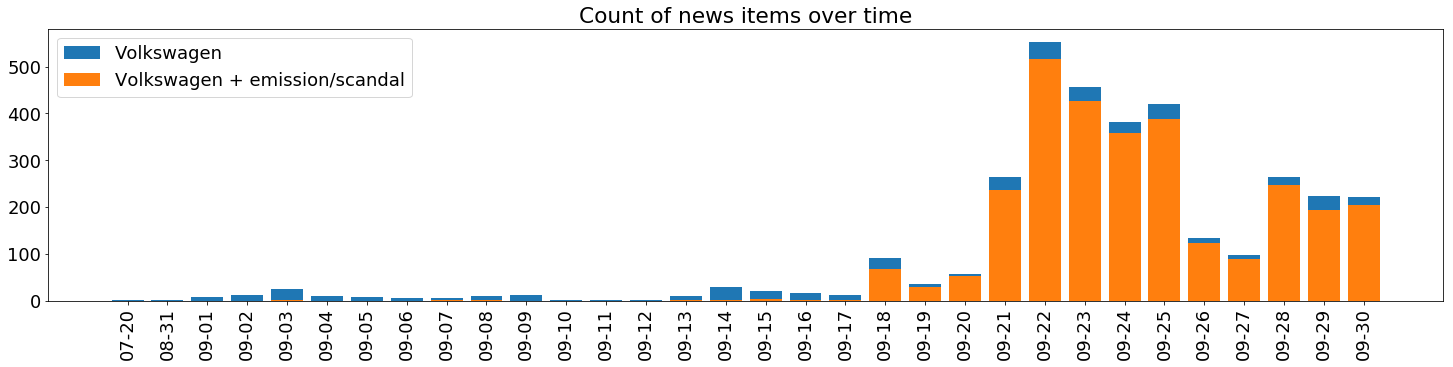

Total number of news mentionning "Volkswagen": 3381
Total number of news mentionning "Volkswagen" and "emission/scandal": 2939


In [150]:
# Re-plot the new dataset
plot_counts(D_VW_f, D_VWS_f)

## 2.4 Possible further invesigation:
* Alternative representations, e.g. doc2vec, only using entities
* Consider temporal priors, as the closer to the major events, the likelihood that an article is about VW also increases.
* Consider synonyms of the VW emission scandal, e.g. dieselgate, emissiongate.
* However, without ground truth, variations of different representations/similarity measures are not comparable, so we do not go further here.

<a id="sentiment_analysis"></a>

# 3. Sentiment analysis on the news items

## 3.1 Method
* Sentiment annotation: using off the shelf package varder from NLTK
* Questions to be answered:
    - **Q1: How does sentiment towards VW change over time: before, during, and after the scandal roll out?**
    - **Q2: How large is the impact of the pos/neg sentiments? **


### Preperation functions
* Measuring sentiments over title and content
* Plot sentiment change over time

In [157]:
# Set up for sentiment analysis
vader = SentimentIntensityAnalyzer()

# Sentiment of the document as a whole
def doc_sentiment(docs):
    doc_sentiments = []
    for d in docs:
        score = vader.polarity_scores(d['content'])
        doc_sentiments.append((d['id'], score, d['published']))
    return doc_sentiments

# Sentiment of the title
def title_sentiment(docs):
    title_sentiments = []
    for d in docs:
        score = vader.polarity_scores(d['title'])
        title_sentiments.append((d['id'], score, d['published']))
    return title_sentiments   

In [185]:
def sentiment_over_time(sent_scores, title=None):
    # Reduce the publishing time to just month-date
    sent_scores = [[t[0], t[1], util.get_date(t[2]).replace('2015-', '')] for t in sent_scores]
    
    # group by publishing date
    sent_scores.sort(key=lambda x: x[2])
    TS = []
    for k, g in it.groupby(sent_scores, lambda x: x[2]):
        X = [x[1] for x in g]
        TS.append((k, X))
    
    # Compute count of pos, neg, neu items each day
    Y_count_pos = np.array([len([x for x in scores[1] if x['compound']>0]) for scores in TS])
    Y_count_neg = -np.array([len([x for x in scores[1] if x['compound']<0]) for scores in TS])
    Y_count_neu = np.array([len([x for x in scores[1] if x['compound']==0]) for scores in TS])
    # Compute the pos vs. neg ratios each day (take a log for better visualisation)
    # Lap. smoothing: add 1 to avoid divided by 0.
    Y_ratio_pos_vs_neg = np.log((Y_count_pos+1)/(-Y_count_neg+1))
    
    # Visualize
    fig, ax1 = plt.subplots(figsize=(25, 5))
    
    # X-axis: Dates as labels
    Xlabels = [x[0] for x in TS]
    X = range(len(Xlabels))
    
    # Y-axis: bar plot for pos, neu, neg counts, axis label on left side
    bar_width = 0.8
    neu_bars = ax1.bar(X, Y_count_neu, bar_width, label='neural')
    pos_bars = ax1.bar(X, Y_count_pos, bar_width, bottom=Y_count_neu, color='g', label='positive')
    neg_bars = ax1.bar(X, Y_count_neg, bar_width, color='r', label='negative')
    ax1.set_xticks(range(len(Xlabels)))
    ax1.set_xticklabels(Xlabels, rotation='vertical')
    ax1.set_ylabel('Count of sentimented items')
    min_y, max_y = ax1.get_ylim()
    ax1.set_ylim(-(max_y - min_y)/2, (max_y - min_y)/2)
    ax1.set_ylim(-600, 600)
    
    # Y-axis: line plot for pos vs. neg ratio, axis label on right side
    ax2 = ax1.twinx()
    ratio, = ax2.plot(X, Y_ratio_pos_vs_neg, label='pos/neg ratio')
    ax2.set_ylabel('ratio between pos and neg items')
    #ax2.set_ylim(-2, 2)
    min_y, max_y = ax2.get_ylim()
    ax2.set_ylim(-(max_y - min_y)/2, (max_y - min_y)/2)
    ax2.set_ylim(-3, 3)
    
    plt.title(title)
    plt.legend(handles=[neu_bars, pos_bars, neg_bars, ratio], loc=3)
    plt.show()

In [181]:
# Compute sentiment scores over news content and titles
doc_scores = doc_sentiment(D_VW_f)
title_scores = title_sentiment(D_VW_f)

## 3.2 Sentiment over time
### Method
For this task, we look at all the data about Volkswagen, i.e. not filtered by keywords "scandal/emission", as we want to see the overall sentiments towards the company.
- We plot the count of positive, negative, neutral items for each day
- We plot the ratio of positive vs. negative items for each day
- We measure sentiment of a news/blog item using the content and the title
 
### Observations - Q1: How does sentiment towards VW change over time: before, during, and after the scandal roll out?
1. The change of sentiment follows the progress and checkpoints of the event:
    - Initial negative sentiment appears around **09-03** when EPA initially brought up threatens, but not obvious.
    - Sharp drop of pos/neg sentiment ratio, and increase of negative sentiments after **09-18** following the public announcement of EPA.
    - Negative sentiments reaches peak on **09-22** when VW admitted its violation, and continued for a few days
    - Another small peak of negative sentiments appear on **09-28** as the suspensions were announced.
2. In both cases (title or content), sentiment change have similar trend, which makes sense. 
3. It seems that when measured by titles, more "positive" content are identified as "neutral", while the number of negative items remain similar --> **not good for the company reputation as people may only read the headlines**.

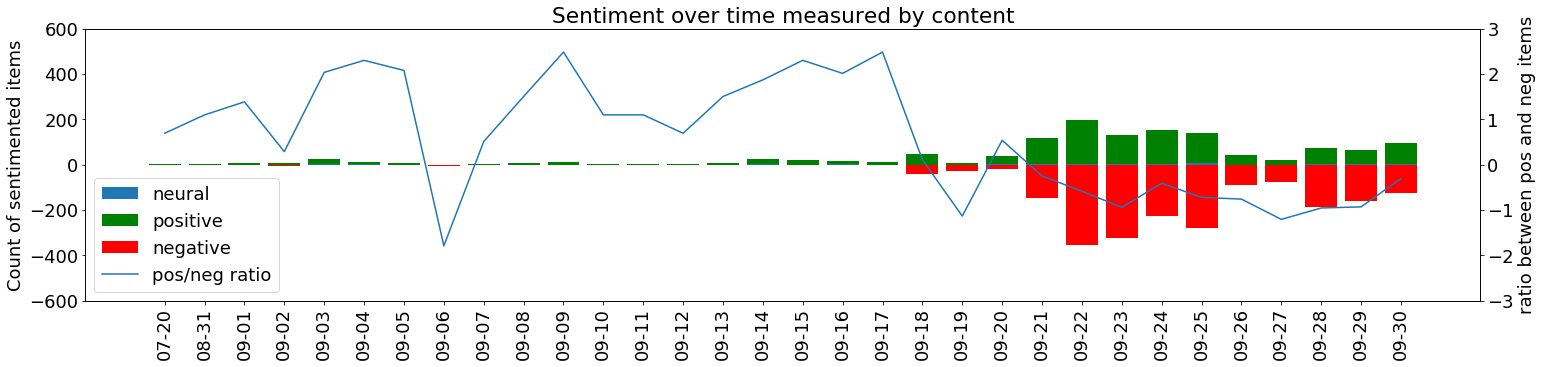

In [186]:
sentiment_over_time(doc_scores, title='Sentiment over time measured by content')

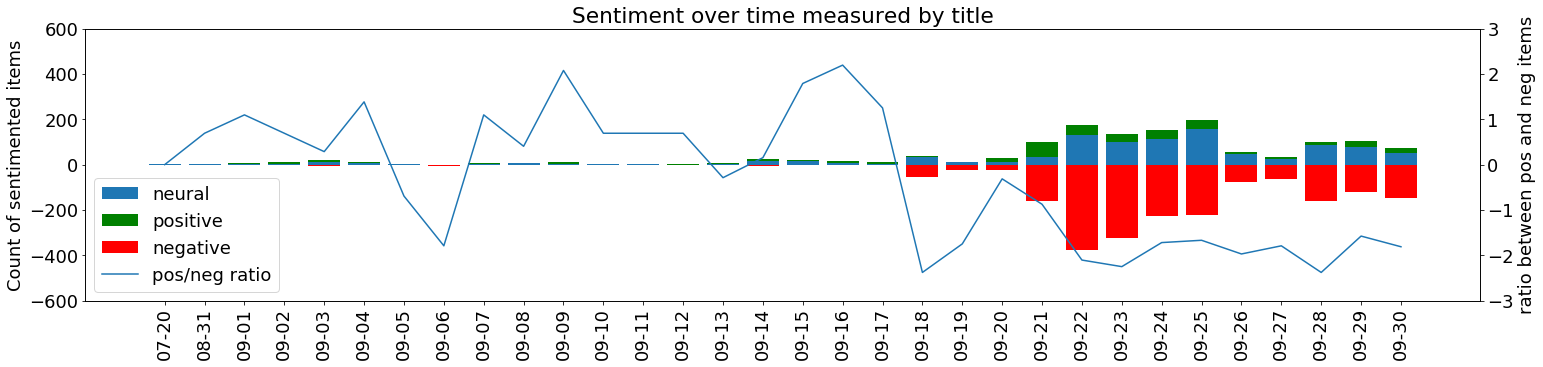

In [187]:
sentiment_over_time(title_scores, title='Sentiment over time measured by title')

## 3.3 Sentiment impact by newspaper cirulation


In [190]:
X = [d['source'] for d in D_VW if d['media-type'] == 'News']
X.sort()
for k, g in it.groupby(X):
    print(k, len(list(g)))

1010 WCSI 2
102.1 The Bull 1
104.7 Minster FM 1
1070wapi.com 3
1150 WJBO 1
12 News Now 1
14 WFIE 6
1440 WNFL 4
1490Wosh.com 1
19 Action News 4
24/7 Wall St 3
3 News 3
3D Car Shows 1
3FM Isle of Man 6
4 Traders 61
4029 TV 3
50connect.co.uk 1
570News 1
580 CFRA 3
610 CKTB 3
640 Toronto 1
660 News 2
680 News 2
7 News Online 1
790 KGMI 1
91.5 KIOS-FM 1
92.9 WLMI 5
94.5 KSMB 3
96.4 Eagle Radio 2
96.7 Kiss FM 1
970AM WZAN 1
997TheLake.com 1
997WTN.com 2
9News.com.au 1
A.M. Best 5
AA Mozambique 1
ABC News 8
ABC Online 1
ABC Radio Australia 1
ABC30 1
ABC6.com 4
ABP Live 1
ACQ Magazine 1
ACTMedia.eu 1
ADVFN India 16
ADVFN UK 21
AEC News Room 1
AGI.it 1
AIADA 1
AM 1540 WBCO 1
AM 620 KPOJ 1
AM Online 3
APC VS PDP NIGERIA 9
ARY News.tv 1
AZCentral.com 2
Aastocks.com 1
Abu Dhabi National 2
Abu Dhabi News.Net 3
AccessAtlanta 1
AccountingWeekly.com 1
Accrington Observer 1
Accuracy in Media 1
Adelaide Now 3
Adrian Daily Telegram 1
Advisen FPN 1
Advisor.ca 1
AfghanistanNews.Net 3
Africa News Network7 1

WTRF 2
WUKY 2
WUWM 2
WVTM 13 1
WWNO 1
WXOK-AM 2
WXTX Fox 54 4
WYFF4.com 7
WYNK-FM 101.5 1
WYOU 1
Wagin Argus 1
Wakefield Express 1
Wales Online 1
Wall St. Cheat Sheet 1
Wall Street Business Network 21
Wall Street Select 11
WallStreetScope.com 1
Wandsworth Guardian 2
Wards 3
Wards Auto.com 4
Warrington Guardian 2
Warrnambool Standard 2
Warwick Courier 2
Washington Post 22
Waterford News & Star 1
Waterloo Region Record 1
Watertown Daily Times 1
Watford Observer 3
Wauchope Gazette 1
WeAreIowa.com 1
Webindia123 1
Webster Post 1
Wellington Times 1
West Australian 13
West Coast Sentinel 1
West Hartford News 1
West Midlands Express & Star 3
West Sussex Today 1
Western Daily Press 1
Western Telegraph 1
Westmorland Gazette 1
Wetherby News 2
Wexford Echo 1
Wharf.co.uk 1
Wharfedale & Airedale Observer 1
What Car? 2
WhatGreenCar 1
Wheels 1
Wheels Within Wales 1
Wheels.ca 1
Wheels24 1
WheelsMag.com.au 4
Whistler Question 1
Wichita Eagle 10
Wicked Local Bourne 1
Wicked Local Bridgewater 1
Wicked Loc

## Appendix: Code for manual inspection

In [139]:
# Insepct samples of news items considering title mention and similarity scores.
out_ = [(sims[docid_idx_map[x['id']]], x) for x in out_title]
in_ = [(sims[docid_idx_map[x['id']]], x) for x in in_title]

def get_sample(min_score, max_score, count):
    items = list(filter(lambda x: min_score <= x[0]<=max_score, in_))
    random.shuffle(items)
    return items[0:count]

"""
# Uncomment to inspect top 50 items without title mention, sorted by similarity to WP_VW article
#
out_.sort(key=lambda x: x[0], reverse=True)
for x in out_[0:50]:
    print('title:', x[1]['title'], x[1]['published'], x[1]['source'], x[0])
    print(re.sub('\s+', ' ', x[1]['content'][0:2000]))
    print('======')
    print()
"""
"""   
# Uncomment to inspect top 50 dissimilar items with title mention
# sorted by similarity to WP_VW articles
#
in_.sort(key=lambda x: x[0])
# A random sample of 50 items from lowest 5% of the items
count = int(len(in_)*5/100)
sample = in_[0:count]
for x in sample[50:100]:
    print('title:', x[1]['title'], x[1]['published'], x[1]['source'], x[0])
    print(re.sub('\s+', ' ', x[1]['content'])[0:2000])
    print('======')
    print()
"""
"""
# Uncomment to inspect random samples of items with title mention 
# in different ranges of similarity scores to the WP_VW page.
for interval in [(0, 0.05), (0.05, 0.1), (0.1, 0.2), (0.2, 0.3)]:
    sample = get_sample(interval[0], interval[1], 10)
    for x in sample:
        print('title:', x[1]['title'], x[1]['published'], x[1]['source'], x[0])
        print(re.sub('\s+', ' ', x[1]['content'])[0:2000])
        print('======')
        print()
"""
print()